In [1]:
import sys
sys.path.append("../../")
import qsimcirq
import cirq
import numpy as np
import importlib
importlib.reload(qsimcirq)
import matplotlib.pyplot as plt
from typing import List

sys.path.append("../weightedMaxCut")
import grouping_cascades
import gen_weightedMaxCut

import random
import time
import concurrent.futures

In [2]:
def generate_bitstrings(n):
    return [i for i in range(2**n)]

In [3]:
def run_qsimh(n:int, k:List[int], p:int, r:int, w:int, circuit_block:cirq.circuits.circuit.Circuit):
    """runs the qsimh simulation of a given cirq circuit 
    Note that joint cutting is only performed if you partition the desired gates as a block via `qsimcirq.BlockGate`.

    Args:
        n (int): number of qubits in the system
        k (List[int]): denotes which qubits are in which partition in the cut, e.g. k=[0,1] means that qubit 0 and 1 are in the first partition and qubit 2... in the other
        p (int): number of prefix gates
        r (int): number of root gates
        w (int): prefix value
        circuit_block (cirq.circuits.circuit.Circuit): circuit to be simulated

    Returns:
        resulting statevector as array
    """
    options = {}
    options['k'] = k
    options['p'] = p
    options['r'] = r
    options['w'] = w

    qsimh_simulator = qsimcirq.QSimhSimulator(options)
    results = qsimh_simulator.compute_amplitudes(
        circuit_block, bitstrings=generate_bitstrings(n))

    return results

In [4]:
def run_qsim(n:int, circuit_noblock:cirq.circuits.circuit.Circuit):
    """runs qsim simulation of a given cirq circuit. 
    Note that this CANNOT handle circuits containing `qsimcirq.BlockGate`. Only qsimh can handle such blocks.

    Args:
        n (int): number of qubits in the system
        circuit_noblock (cirq.circuits.circuit.Circuit): circuit to be simulated

    Returns:
        resulting statevector as array
    """
    qsim_simulator = qsimcirq.QSimSimulator()
    results = qsim_simulator.compute_amplitudes(circuit_noblock, bitstrings=generate_bitstrings(n))
    return results

### Bell state preparation

In [5]:
# Define qubits
n=3
q0 = cirq.LineQubit(0)
q1 = cirq.LineQubit(1)
q2 = cirq.LineQubit(2)

block_gate2 = qsimcirq.BlockGate([
    cirq.CNOT(q1, q0),
    cirq.CNOT(q1, q2)
])

# Create a circuit and add the BlockOperation
circuit_block = cirq.Circuit(
    cirq.H(q1),
    block_gate2(q0,q1,q2),  # Add the BlockOperation directly

)
print("Circuit (block):")
print(circuit_block)


Circuit (block):
0: ───────BlockGate(CNOT(q(1), q(0)), CNOT(q(1), q(2)))───
          │
1: ───H───#2──────────────────────────────────────────────
          │
2: ───────#3──────────────────────────────────────────────


In [6]:
circuit_noblock = cirq.Circuit(
    cirq.H(q1),
    cirq.CNOT(q1, q0),
    cirq.CNOT(q1, q2)    
)
print("Circuit (no block):")
print(circuit_noblock)

Circuit (no block):
0: ───────X───────
          │
1: ───H───@───@───
              │
2: ───────────X───


In [7]:
results_0 = run_qsimh(n, [0], 0, 1, 0, circuit_block)
print("qsimh result:")
print(results_0)

rmax: 2
smax: 1
Number of Feynman Paths: 2
qsimh result:
[(0.7071067690849304+0j), (8.429368136830817e-08+0j), 0j, 0j, 0j, 0j, (8.429367426288081e-08+0j), (0.7071065902709961+0j)]


In [8]:
results_noblock = run_qsim(n, circuit_noblock)
print("qsim results:")
print(results_noblock)

qsim results:
[(0.7071067690849304+0j), 0j, 0j, 0j, 0j, 0j, 0j, (0.7071067690849304+0j)]


In [9]:
results_0 = np.array(results_0)
results_noblock = np.array(results_noblock)
np.linalg.norm(results_0 - results_noblock)

2.149075879269111e-07

### A circuit with quite random gates

In [10]:
# Define qubits
n=3
q0 = cirq.LineQubit(0)
q1 = cirq.LineQubit(1)
q2 = cirq.LineQubit(2)

theta1 = 0.24
theta2 = 1.34

block_gate2 = qsimcirq.BlockGate([
    cirq.CXPowGate(exponent=theta1/np.pi, global_shift=-0.5).on(q2,q0),
    cirq.CXPowGate(exponent=theta2/np.pi, global_shift=-0.5).on(q1,q0),
    cirq.PhasedISwapPowGate(phase_exponent=2.5, exponent=2.1, global_shift=0.2).on(q2,q0),
    cirq.givens(angle_rads=0.2).on(q1,q0),  
])

# Create a circuit and add the BlockOperation
circuit_block = cirq.Circuit(
    cirq.H(q0),
    cirq.H(q1),
    cirq.H(q2),
    block_gate2(q0,q1,q2),  # Add the BlockOperation directly

)

print("Circuit (block):")
print(circuit_block)


Circuit (block):
0: ───H───BlockGate(CNOT**0.07639437268410976(q(2), q(0)), CNOT**0.4265352474862795(q(1), q(0)), PhasedISWAP(exponent=2.1, global_shift=0.2)(q(2), q(0)), PhasedISWAP**0.12732395447351627(q(1), q(0)))───
          │
1: ───H───#2──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          │
2: ───H───#3──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [11]:
circuit_noblock = cirq.Circuit(
    cirq.H(q0),
    cirq.H(q1),
    cirq.H(q2),
    cirq.CXPowGate(exponent=theta1/np.pi, global_shift=-0.5).on(q2,q0),
    cirq.CXPowGate(exponent=theta2/np.pi, global_shift=-0.5).on(q1,q0),
    cirq.PhasedISwapPowGate(phase_exponent=2.5, exponent=2.1, global_shift=0.2).on(q2,q0),
    cirq.givens(angle_rads=0.2).on(q1,q0), 
)
print("Circuit (no block):")
print(circuit_noblock)

Circuit (no block):
0: ───H───X^(1/13)───X^0.427───PhISwap(0.5)────────PhISwap(0.25)─────────
          │          │         │                   │
1: ───H───┼──────────@─────────┼───────────────────PhISwap(0.25)^0.127───
          │                    │
2: ───H───@────────────────────PhISwap(0.5)^-1.9─────────────────────────


In [12]:
results_0 = run_qsimh(n, [0], 0, 1, 0, circuit_block)
print("qsimh result:")
print(results_0)

qsimh result:
[(0.2488468885421753-0.25114771723747253j), (-0.20649489760398865+0.2869838774204254j), (0.20286230742931366-0.1891266256570816j), (-0.15294063091278076+0.23136794567108154j), (-0.25181710720062256+0.3311586380004883j), (0.2849107086658478-0.3031563460826874j), (-0.2064949870109558+0.2869838774204254j), (0.24884681403636932-0.25114771723747253j)]
rmax: 4
smax: 1
Number of Feynman Paths: 4


In [13]:
results_noblock = run_qsim(n, circuit_noblock)
print("qsim results:")
print(results_noblock)

qsim results:
[(0.2488468736410141-0.2511478066444397j), (-0.2064950168132782+0.2869839668273926j), (0.20286229252815247-0.18912667036056519j), (-0.15294063091278076+0.2313680499792099j), (-0.25181710720062256+0.3311587870121002j), (0.28491073846817017-0.3031564950942993j), (-0.2064950168132782+0.2869839668273926j), (0.2488468736410141-0.2511478066444397j)]


In [14]:
results_0 = np.array(results_0)
results_noblock = np.array(results_noblock)
np.linalg.norm(results_0 - results_noblock)

3.3052374441651755e-07

### Block with empty qubits

In [15]:
# Define qubits
n=4
q0 = cirq.LineQubit(0)
q1 = cirq.LineQubit(1)
q2 = cirq.LineQubit(2)
q3 = cirq.LineQubit(3)

block_gate2 = qsimcirq.BlockGate([
    cirq.CNOT(q0, q1),
    cirq.CNOT(q0, q3)
])

# Create a circuit and add the BlockOperation
circuit_block = cirq.Circuit(
    cirq.H(q0),
    cirq.H(q2),
    block_gate2(q0,q1,q3),  # Add the BlockOperation directly

)
print("Circuit (block):")
print(circuit_block)


Circuit (block):
0: ───H───BlockGate(CNOT(q(0), q(1)), CNOT(q(0), q(3)))───
          │
1: ───────#2──────────────────────────────────────────────
          │
2: ───H───┼───────────────────────────────────────────────
          │
3: ───────#3──────────────────────────────────────────────


In [16]:
circuit_noblock = cirq.Circuit(
    cirq.H(q0),
    cirq.H(q2),
    cirq.CNOT(q0, q1),
    cirq.CNOT(q0, q3)  
)
print("Circuit (no block):")
print(circuit_noblock)

Circuit (no block):
0: ───H───@───@───
          │   │
1: ───────X───┼───
              │
2: ───H───────┼───
              │
3: ───────────X───


In [17]:
results_0 = run_qsimh(n, [0], 0, 1, 0, circuit_block)
print("qsimh result:")
print(results_0)

qsimh result:
[(0.4999999701976776+0j), (3.8531211998815706e-08+0j), (0.4999999701976776+0j), (3.8531211998815706e-08+0j), 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, (5.960463056453591e-08+0j), (0.49999988079071045+0j), (5.960463056453591e-08+0j), (0.49999988079071045+0j)]
rmax: 2
smax: 1
Number of Feynman Paths: 2


In [18]:
results_noblock = run_qsim(n, circuit_noblock)
print("qsim results:")
print(results_noblock)

qsim results:
[(0.4999999701976776+0j), 0j, (0.4999999701976776+0j), 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, (0.4999999701976776+0j), 0j, (0.4999999701976776+0j)]


In [19]:
results_0 = np.array(results_0)
results_noblock = np.array(results_noblock)
np.linalg.norm(results_0 - results_noblock)

1.6143712125861026e-07

### Random circuit with flipped gates and sometimes empty qubits in the blocks

In [20]:
# Define qubits
n=10
q0 = cirq.LineQubit(0)
q1 = cirq.LineQubit(1)
q2 = cirq.LineQubit(2)
q3 = cirq.LineQubit(3)
q4 = cirq.LineQubit(4)
q5 = cirq.LineQubit(5)
q6 = cirq.LineQubit(6)
q7 = cirq.LineQubit(7)
q8 = cirq.LineQubit(8)
q9 = cirq.LineQubit(9)

theta1 = 0.24
theta2 = 1.34
theta3 = 1.25
theta4 = 9.23

block_gate1 = qsimcirq.BlockGate([
    cirq.CXPowGate(exponent=theta1/np.pi, global_shift=-0.5).on(q6,q0),
    #cirq.CXPowGate(exponent=theta2/np.pi, global_shift=-0.5).on(q3,q0),
    cirq.PhasedISwapPowGate(phase_exponent=2.5, exponent=2.1, global_shift=0.2).on(q2,q0),
    #cirq.givens(angle_rads=0.2).on(q1,q0),  
    cirq.CX(q1, q0)
])

block_gate2 = qsimcirq.BlockGate([
    cirq.ZZPowGate(exponent=theta3/np.pi, global_shift=-0.5).on(q4,q8),
    cirq.ZZPowGate(exponent=theta3/np.pi, global_shift=-0.5).on(q4,q9)
])

block_gate3 = qsimcirq.BlockGate([
    cirq.ZZPowGate(exponent=theta4/np.pi, global_shift=-0.5).on(q3,q7),
    cirq.ZZPowGate(exponent=theta4/np.pi, global_shift=-0.5).on(q3,q8)
])



# Create a circuit and add the BlockOperation
circuit_block = cirq.Circuit(
    cirq.H(q0),
    cirq.H(q1),
    cirq.H(q2),
    cirq.H(q3),
    cirq.H(q4),
    cirq.H(q5),
    cirq.H(q6),
    cirq.H(q7),
    cirq.H(q8),
    cirq.H(q9),
    block_gate1(q0,q1,q2,q6),
    block_gate2(q4, q8 , q9),
    block_gate3(q3, q7, q8)
)

print("Circuit (block):")
print(circuit_block)


Circuit (block):
          ┌────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
0: ───H────BlockGate(CNOT**0.07639437268410976(q(6), q(0)), PhasedISWAP(exponent=2.1, global_shift=0.2)(q(2), q(0)), CNOT(q(1), q(0)))───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           │
1: ───H────#2────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           │
2: ───H────#3───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [21]:
circuit_noblock = cirq.Circuit(
    cirq.H(q0),
    cirq.H(q1),
    cirq.H(q2),
    cirq.H(q3),
    cirq.H(q4),
    cirq.H(q5),
    cirq.H(q6),
    cirq.H(q7),
    cirq.H(q8),
    cirq.H(q9),

    cirq.CXPowGate(exponent=theta1/np.pi, global_shift=-0.5).on(q6,q0),
    #cirq.CXPowGate(exponent=theta2/np.pi, global_shift=-0.5).on(q3,q0),
    cirq.PhasedISwapPowGate(phase_exponent=2.5, exponent=2.1, global_shift=0.2).on(q2,q0),
    #cirq.givens(angle_rads=0.2).on(q1,q0),  
    cirq.CX(q1, q0),

    cirq.ZZPowGate(exponent=theta3/np.pi, global_shift=-0.5).on(q4,q8),
    cirq.ZZPowGate(exponent=theta3/np.pi, global_shift=-0.5).on(q4,q9),

    cirq.ZZPowGate(exponent=theta4/np.pi, global_shift=-0.5).on(q3,q7),
    cirq.ZZPowGate(exponent=theta4/np.pi, global_shift=-0.5).on(q3,q8)
    
)
print("Circuit (no block):")
print(circuit_noblock)

Circuit (no block):
          ┌──────────────────────────┐   ┌───────────────────────────┐
0: ───H────X^(1/13)───────────────────────PhISwap(0.5)───────────────────X───
           │                              │                              │
1: ───H────┼──────────────────────────────┼──────────────────────────────@───
           │                              │
2: ───H────┼──────────────────────────────PhISwap(0.5)^-1.9──────────────────
           │
3: ───H────┼───────────────ZZ──────────────────────────────ZZ────────────────
           │               │                               │
4: ───H────┼───────ZZ──────┼──────────────ZZ───────────────┼─────────────────
           │       │       │              │                │
5: ───H────┼───────┼───────┼──────────────┼────────────────┼─────────────────
           │       │       │              │                │
6: ───H────@───────┼───────┼──────────────┼────────────────┼─────────────────
                   │       │              │     

In [22]:
results_0 = run_qsimh(n, [0,1,2,3,4], 0, 1, 0, circuit_block)
print("qsimh result:")
print(results_0)

qsimh result:
[(-0.012041797861456871+0.028836717829108238j), (-0.031162647530436516-0.002334616845473647j), (0.031025247648358345-0.003741005202755332j), (0.013333111070096493+0.02826286479830742j), (0.0062327999621629715-0.030622107908129692j), (0.031025247648358345-0.003741005202755332j), (-0.029714517295360565+0.009675147943198681j), (-0.01855122111737728-0.025147832930088043j), (-0.012041797861456871+0.028836717829108238j), (-0.031162647530436516-0.002334615681320429j), (0.031025245785713196-0.003741005202755332j), (0.013333112932741642+0.028262866660952568j), (0.006232800427824259-0.030622106045484543j), (0.031025245785713196-0.003741005202755332j), (-0.029714517295360565+0.009675147011876106j), (-0.01855122298002243-0.025147832930088043j), (-0.012041797861456871+0.028836717829108238j), (-0.031162647530436516-0.002334616845473647j), (0.031025247648358345-0.003741005202755332j), (0.013333111070096493+0.02826286479830742j), (0.0062327999621629715-0.030622107908129692j), (0.03102524

In [23]:
results_1 = run_qsimh(n, [0,1,2,3,4], 0, 1, 0, circuit_noblock)
print("qsimh result:")
print(results_1)

qsimh result:
[(-0.012041800655424595+0.028836730867624283j), (-0.031162668019533157-0.002334618242457509j), (0.031025264412164688-0.003741007996723056j), (0.01333311852067709+0.028262875974178314j), (0.006232804618775845-0.030622120946645737j), (0.031025264412164688-0.0037410070654004812j), (-0.029714535921812057+0.009675153531134129j), (-0.01855122670531273-0.025147847831249237j), (-0.012041800655424595+0.028836730867624283j), (-0.031162668019533157-0.002334618242457509j), (0.031025264412164688-0.003741007996723056j), (0.01333311852067709+0.028262875974178314j), (0.006232804618775845-0.030622120946645737j), (0.031025264412164688-0.0037410070654004812j), (-0.029714535921812057+0.009675153531134129j), (-0.01855122670531273-0.025147847831249237j), (-0.012041800655424595+0.028836730867624283j), (-0.031162668019533157-0.002334618242457509j), (0.031025264412164688-0.003741007996723056j), (0.01333311852067709+0.028262875974178314j), (0.006232804618775845-0.030622120946645737j), (0.031025264

In [24]:
results_0 = np.array(results_0)
results_1 = np.array(results_1)
np.linalg.norm(results_0 - results_1)

4.4706963921231326e-07

### Small instance of QAOA for Max Cut

#### $q=20$

In [25]:
q = 20
seed = 16
cut_loc = 9
sizes = [10,10]
p_intra = 0.8
p_inter = 0.05
angles = [1.55739, 2.32636]
save_plot = False
verbose = True

Cascades prior to limiting their size
('19', [(1, 19), (3, 19), (7, 19)])
('1', [(1, 17)])
('3', [(3, 14)])
('15', [(5, 15), (6, 15)])
('0', [(0, 13)])
('remainder', [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 9), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (4, 7), (4, 8), (5, 7), (5, 8), (5, 9), (6, 7), (6, 8), (6, 9), (7, 8), (7, 9), (8, 9), (10, 11), (10, 12), (10, 13), (10, 14), (10, 15), (10, 16), (10, 17), (10, 18), (10, 19), (11, 13), (11, 14), (11, 16), (11, 17), (11, 18), (11, 19), (12, 13), (12, 14), (12, 16), (12, 17), (12, 19), (13, 14), (13, 15), (13, 16), (13, 17), (13, 18), (13, 19), (14, 16), (14, 17), (14, 18), (14, 19), (15, 16), (15, 17), (15, 18), (15, 19), (16, 17), (16, 18), (16, 19), (17, 19), (18, 19)])
Cascades after limiting their size
('remainder', [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 2), 

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


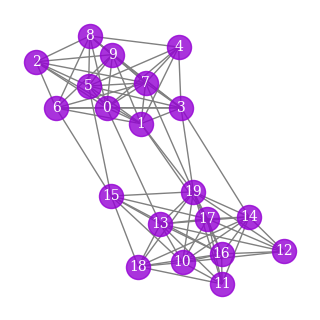

In [26]:
maxcut = gen_weightedMaxCut.WeightedMaxCut(q, seed, cut_loc, sizes, p_intra, p_inter, angles, save_plot, verbose)
weights = [random.uniform(0, 2 * np.pi) for _ in range(len(maxcut.G.edges))]
maxcut = gen_weightedMaxCut.WeightedMaxCut(q, seed, cut_loc, sizes, p_intra, p_inter, angles, save_plot, verbose, weights)
circ_objs = maxcut.run_all_cirq([1,2])

In [27]:
circuit_noblock, circuit_block = circ_objs

In [28]:
circuit_block

┌──────────────────┐   ┌─────────────────┐   ┌────────────────────────┐   ┌────────────────────────┐   ┌───────────────────────────┐   ┌────────────────────────────────────┐   ┌──────────────────────────────────┐   ┌───────────────────────────┐   ┌──────────────────────────────────┐   ┌───────────────────────────┐   ┌───────────────────────────┐   ┌──────────────────┐   ┌────────────────┐   ┌─────────────────────────────────────────────────────────────────────────────────────────────┐                ┌───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐   ┌─────────────────────────────┐
0: ────H───ZZ──────────ZZ───────────ZZ─────────────────────ZZ────────────────────ZZ───────────────────────────ZZ───────────────────────────ZZ──────────────────────────────ZZ───────────────────────────────────────ZZ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────ZZ───────────Rx(0.741π)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           │           │            │                      │                     │                            │                            │                               │                                        │                                                                                                                                                                │
1: ────H───ZZ^-0.421───┼────────────┼────────ZZ────────────┼────────ZZ───────────┼───────ZZ───────────────────┼───────ZZ───────────────────┼───────ZZ──────────────────────┼─────────ZZ─────────────────────────────┼──────────────────────────────────────ZZ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────BlockGate(ZZ**2.230064844307799(q(1), q(19)), ZZ**1.579430276471318(q(3), q(19)), ZZ**0.799142294962403(q(7), q(19)))───────────────ZZ───────────────────────────────Rx(0.741π)───
                       │            │        │             │        │            │       │                    │       │                    │       │                       │         │                              │                                      │                                                                                                                         │                                                                                                                                                                       │                                                                                                                                   │
2: ────H───────────────ZZ^-0.907────┼────────ZZ^-0.632─────┼────────┼────────────┼───────┼────────────────────┼───────┼────────────────────┼───────┼────────ZZ─────────────┼─────────┼───────ZZ─────────────────────┼───────ZZ─────────────────────────────┼─────────ZZ────────────────────ZZ─────────────────────────────────────Rx(0.741π)─────────────────────────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────────────────────────────────────
                                    │                      │        │            │       │                    │       │  

In [29]:
circuit_noblock

┌──────────────────┐   ┌────────────────┐   ┌────────────────┐   ┌────────────────────────┐   ┌──────────────────────────┐   ┌─────────────────────────────────┐   ┌────────────────────────────────┐   ┌─────────────────────────────────┐   ┌───────────────────────────────────┐   ┌───────────────────────────────────┐   ┌────────────────────────────┐   ┌──────────────────────────┐   ┌──────────────────────────┐   ┌──────────────────┐   ┌──────────────────────────┐   ┌───────────────────┐   ┌─────────────────┐   ┌─────────────────────────┐   ┌─────────────────────────────────┐   ┌───────────────────────────┐   ┌──────────────────────────────────┐   ┌───────────────────────────┐   ┌───────────────────────────┐   ┌──────────────────┐
0: ────H───ZZ──────────ZZ───────────ZZ─────────────────────ZZ───────────────────ZZ───────────────────ZZ───────────────────────────ZZ─────────────────────────────ZZ────────────────────────────────────ZZ───────────────────────────────────ZZ────────────────────────────────────Rx(0.741π)──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           │           │            │                      │                    │                    │                            │                              │                                     │                                    │
1: ────H───ZZ^-0.421───┼────────────┼────────ZZ────────────┼───────ZZ───────────┼───────ZZ───────────┼───────ZZ───────────────────┼───────ZZ─────────────────────┼───────ZZ────────────────────────────┼────────────────────────────────────┼───────ZZ────────────────────────────ZZ──────────────────────────────────────ZZ──────────────────────────────────────Rx(0.741π)──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                       │            │        │             │       │            │       │            │       │                    │       │                      │       │                             │                                    │       │                             │                                       │
2: ────H───────────────ZZ^-0.907────┼────────ZZ^-0.632─────┼───────┼────────────┼───────┼────────────┼───────┼────────────────────┼───────┼───────ZZ─────────────┼───────┼───────ZZ────────────────────┼───────ZZ───────────────────────────┼───────┼───────ZZ────────────────────┼─────────ZZ────────────────────────────┼────────Rx(0.741π)─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                    │                      │       │            │       │            │       │                    │       │       │              │       │       │                     │       │                    

In [30]:
start = time.time()
results_0 = run_qsimh(q, list(range(10)), 0, 1, 0, circuit_block)
end0 = time.time() - start
#print("qsimh result (block):")
#print(results_0)
print("qsimh (block) time: ", end0)

rmax: 2
smax: 16
Number of Feynman Paths: 32
qsimh (block) time:  0.6797857284545898


In [31]:
start = time.time()
results_1 = run_qsimh(q, list(range(10)), 0, 1, 0, circuit_noblock)
end1 = time.time() - start
#print("qsimh result (no block):")
#print(results_1)
print("qsimh (no block) time: ", end1)

rmax: 2
smax: 128
Number of Feynman Paths: 256
qsimh (no block) time:  2.833740711212158


In [32]:
start = time.time()
results_2 = run_qsim(q, circuit_noblock)
end2 = time.time() - start
#print("qsim result (no cut):")
#print(results_2)
print("qsim (no cut) time: ", end2)

qsim (no cut) time:  0.33641862869262695


In [33]:
results_0 = np.array(results_0)
results_2 = np.array(results_2)
try:
    results_1 = np.array(results_1)
    print("Absolute difference between results (HSF joint v.s. separate): ", np.linalg.norm(results_0 - results_1))
except:
    print("Separate HSF was timed out.")
print("Absolute difference between results (HSF joint v.s. no cut): ", np.linalg.norm(results_0 - results_2))

Absolute difference between results (HSF joint v.s. separate):  5.061650562952866e-07
Absolute difference between results (HSF joint v.s. no cut):  4.874518795203769e-07


In [34]:
print("-----TIME RATIOS----")
print("separate/joint = ", end1/end0)
print("Schröd/joint = ", end2/end0)

-----TIME RATIOS----
separate/joint =  4.168579292852062
Schröd/joint =  0.4948892196625454


### $q=24$

In [29]:
q = 24
seed = 10
cut_loc = 11
sizes = [12,12]
p_intra = 0.8
p_inter = 0.05
angles = [1.55739, 2.32636]
save_plot = False
verbose = True

Cascades prior to limiting their size
('20', [(3, 20), (5, 20)])
('4', [(4, 12), (4, 17)])
('17', [(7, 17)])
('2', [(2, 23)])
('23s0', [(8, 22)])
('remainder', [(0, 1), (0, 2), (0, 3), (0, 4), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (1, 4), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (2, 3), (2, 4), (2, 5), (2, 8), (2, 9), (2, 10), (2, 11), (3, 5), (3, 6), (3, 8), (3, 9), (3, 10), (3, 11), (4, 5), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (5, 7), (5, 8), (5, 10), (5, 11), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (7, 8), (7, 11), (8, 9), (8, 10), (8, 11), (9, 10), (9, 11), (10, 11), (12, 13), (12, 14), (12, 15), (12, 16), (12, 17), (12, 18), (12, 19), (12, 21), (12, 22), (12, 23), (13, 15), (13, 16), (13, 17), (13, 18), (13, 19), (13, 20), (13, 21), (13, 22), (13, 23), (14, 15), (14, 16), (14, 17), (14, 19), (14, 20), (14, 21), (14, 22), (14, 23), (15, 16), (15, 17), (15, 18), (15, 20), (15, 21), (15, 22), (15, 23), (16, 17), (16, 18), (16, 20), (16, 21), (16, 22), (17, 18), (1

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


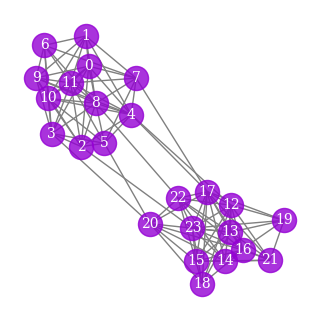

In [30]:
maxcut = gen_weightedMaxCut.WeightedMaxCut(q, seed, cut_loc, sizes, p_intra, p_inter, angles, save_plot, verbose)
weights = [random.uniform(0, 2 * np.pi) for _ in range(len(maxcut.G.edges))]
maxcut = gen_weightedMaxCut.WeightedMaxCut(q, seed, cut_loc, sizes, p_intra, p_inter, angles, save_plot, verbose, weights)
circ_objs = maxcut.run_all_cirq([1,2])

In [31]:
circuit_noblock, circuit_block = circ_objs

In [32]:
circuit_block

┌──────────────────┐   ┌────────────────────────┐   ┌──────────────────────────┐   ┌──────────────────────────────────┐   ┌───────────────────────────┐   ┌──────────────────────────────────────────┐   ┌──────────────────────────────────┐   ┌─────────────────────────────────────────┐   ┌─────────────────────────────────────────────┐   ┌──────────────────────────────────────┐   ┌─────────────────────────────────────┐   ┌─────────────────────────────┐   ┌──────────────────┐   ┌────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐   ┌─────────────────────┐                             ┌───────────────────────────┐
0: ────H───ZZ─────────ZZ─────────ZZ────────────ZZ─────────────────────ZZ───────────────────────────ZZ─────────────────────────────ZZ─────────────────────────────────────ZZ──────────────────────────────ZZ─────────────────────────────────────────────Rx(0.741π)────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           │          │          │             │                      │                            │                              │                                      │                               │
1: ────H───ZZ^(5/8)───┼──────────┼─────────────┼──────────────────────┼────────ZZ──────────────────┼────────ZZ────────────────────┼───────ZZ─────────────────────────────┼────────ZZ─────────────────────┼───────ZZ─────────────────────────────────────ZZ─────────────────────────────────────ZZ────────────────────────────────────────────Rx(0.741π)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                      │          │             │                      │        │                   │        │                     │       │                              │        │                      │       │                                      │                                      │
2: ────H──────────────ZZ^(1/9)───┼─────────────┼────────ZZ────────────┼────────┼───────────────────┼────────┼────────ZZ───────────┼───────┼───────ZZ─────────────────────┼────────┼──────────────────────┼───────┼───────ZZ─────────────────────────────┼─────────ZZ───────────────────────────┼───────ZZ────────────────────────────────────ZZ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────ZZ─────────────────────────────Rx(0.741π)───
                                 │             │        │             │        │                   │        │        │            │       │       │                      │        │                      │       │       │                              │         │                            │       │                              

In [19]:
start = time.time()
results_0 = run_qsimh(q, list(range(10)), 0, 1, 0, circuit_block)
end0 = time.time() - start
#print("qsimh result (block):")
#print(results_0)
print("qsimh (block) time: ", end0)

In [ ]:
start = time.time()
results_1 = run_qsimh(q, list(range(10)), 0, 1, 0, circuit_noblock)
end1 = time.time() - start
#print("qsimh result (no block):")
#print(results_1)
print("qsimh (no block) time: ", end1)

In [ ]:
start = time.time()
results_2 = run_qsim(q, circuit_noblock)
end2 = time.time() - start
#print("qsim result (no cut):")
#print(results_2)
print("qsim (no cut) time: ", end2)

In [ ]:
results_0 = np.array(results_0)
results_2 = np.array(results_2)
try:
    results_1 = np.array(results_1)
    print("Absolute difference between results (HSF joint v.s. separate): ", np.linalg.norm(results_0 - results_1))
except:
    print("Separate HSF was timed out.")
print("Absolute difference between results (HSF joint v.s. no cut): ", np.linalg.norm(results_0 - results_2))

In [ ]:
print("-----TIME RATIOS----")
print("separate/joint = ", end1/end0)
print("Schröd/joint = ", end2/end0)